# Create model LSTM

## Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

## Read the dataset

In [2]:
df=pd.read_csv("../input/nsetataglobalbeverageslimited/NSE-Tata-Global-Beverages-Limited.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


## Analyze the closing prices

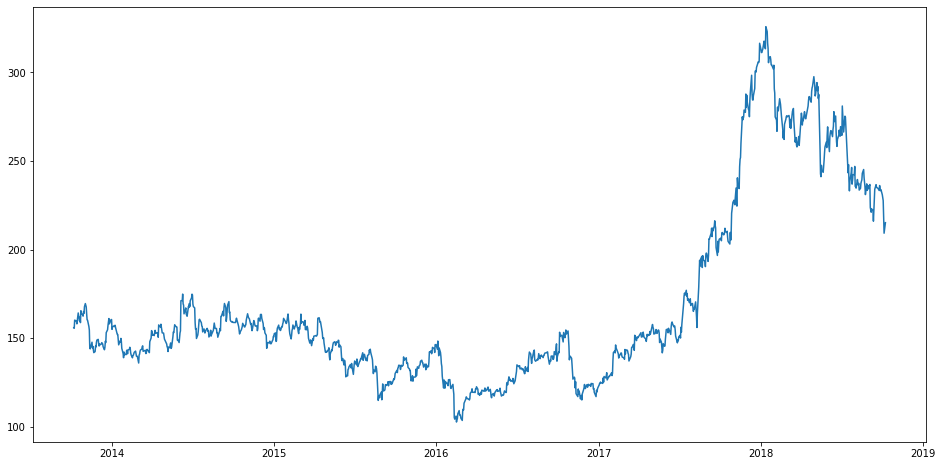

In [3]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

## Sort the dataset on datetime and filter "Date" and "Close" column


In [5]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

## Normalize the dataset

In [9]:
scaler=MinMaxScaler(feature_range=(0,1))
final_dataset=new_dataset.values
train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

#new_dataset.index=new_dataset.Date
#new_dataset.drop("Date",axis=1,inplace=True)
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

## Build and train LSTM model

In [10]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

2022-07-26 13:16:15.419592: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-07-26 13:16:16.057321: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


927/927 - 20s - loss: 0.0012


## Take a sample of a dataset

In [21]:
X_test=[]

for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
    
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

## Save model

In [22]:
lstm_model.save("saved_model.h5")

## Visualize the predicted stock costs with actual stock costs

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


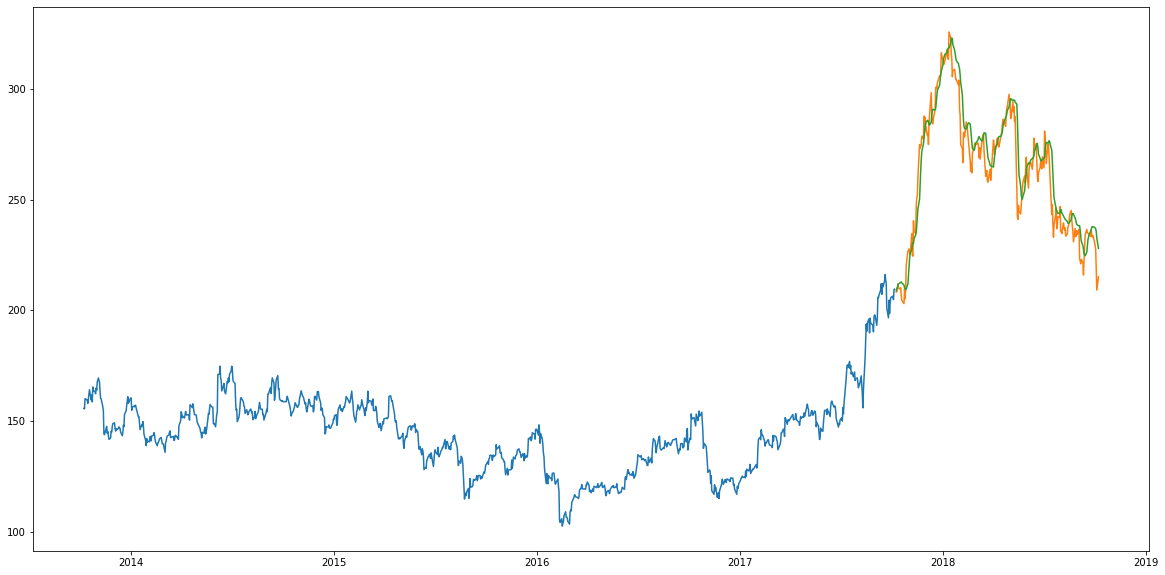

In [23]:
train_data=new_dataset[:987]

valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price

plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])

# Build the dashboard

## Install component

In [24]:
!pip install dash
!pip install dash-html-components
!pip install dash-core-components

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 11.4 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.2/357.2 kB 21.8 MB/s eta 0:00:00


## Create dashboard

In [29]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import plotly.graph_objs as go
from dash.dependencies import Input, Output
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import numpy as np

app = dash.Dash()
server = app.server
scaler=MinMaxScaler(feature_range=(0,1))

df_nse = pd.read_csv("../input/nsetataglobalbeverageslimited/NSE-Tata-Global-Beverages-Limited.csv")
df_nse["Date"]=pd.to_datetime(df_nse.Date,format="%Y-%m-%d")
df_nse.index=df_nse['Date']

data=df_nse.sort_index(ascending=True,axis=0)
new_data=pd.DataFrame(index=range(0,len(df_nse)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_data["Date"][i]=data['Date'][i]
    new_data["Close"][i]=data["Close"][i]
    
new_data.index=new_data.Date
new_data.drop("Date",axis=1,inplace=True)

dataset=new_data.values
train=dataset[0:987,:]
valid=dataset[987:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)

x_train,y_train=[],[]

for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
    
x_train,y_train=np.array(x_train),np.array(y_train)
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

model=load_model("saved_model.h5")

inputs=new_data[len(new_data)-len(valid)-60:].values
inputs=inputs.reshape(-1,1)
inputs=scaler.transform(inputs)

X_test=[]

for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
    
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

closing_price=model.predict(X_test)
closing_price=scaler.inverse_transform(closing_price)

train=new_data[:987]

valid=new_data[987:]
valid['Predictions']=closing_price

df= pd.read_csv("../input/stock-data/stock_data.csv")

app.layout = html.Div([
   
    html.H1("Stock Price Analysis Dashboard", style={"textAlign": "center"}),
   
    dcc.Tabs(id="tabs", children=[
       
        dcc.Tab(label='NSE-TATAGLOBAL Stock Data',children=[
            html.Div([
                html.H2("Actual closing price",style={"textAlign": "center"}),
                dcc.Graph(
                    id="Actual Data",
                    figure={
                        "data":[
                            go.Scatter(
                                x=train.index,
                                y=valid["Close"],
                                mode='markers'
                            )
                        ],
                        "layout":go.Layout(
                            title='scatter plot',
                            xaxis={'title':'Date'},
                            yaxis={'title':'Closing Rate'}
                        )
                    }
                ),
                html.H2("LSTM Predicted closing price",style={"textAlign": "center"}),
                dcc.Graph(
                    id="Predicted Data",
                    figure={
                        "data":[
                            go.Scatter(
                                x=valid.index,
                                y=valid["Predictions"],
                                mode='markers'
                            )
                        ],
                        "layout":go.Layout(
                            title='scatter plot',
                            xaxis={'title':'Date'},
                            yaxis={'title':'Closing Rate'}
                        )
                    }
                )                
            ])                
        ]),
        dcc.Tab(label='Facebook Stock Data', children=[
            html.Div([
                html.H1("Facebook Stocks High vs Lows", 
                        style={'textAlign': 'center'}),
              
                dcc.Dropdown(id='my-dropdown',
                             options=[{'label': 'Tesla', 'value': 'TSLA'},
                                      {'label': 'Apple','value': 'AAPL'}, 
                                      {'label': 'Facebook', 'value': 'FB'}, 
                                      {'label': 'Microsoft','value': 'MSFT'}], 
                             multi=True,value=['FB'],
                             style={"display": "block", "margin-left": "auto", 
                                    "margin-right": "auto", "width": "60%"}),
                dcc.Graph(id='highlow'),
                html.H1("Facebook Market Volume", style={'textAlign': 'center'}),
         
                dcc.Dropdown(id='my-dropdown2',
                             options=[{'label': 'Tesla', 'value': 'TSLA'},
                                      {'label': 'Apple','value': 'AAPL'}, 
                                      {'label': 'Facebook', 'value': 'FB'},
                                      {'label': 'Microsoft','value': 'MSFT'}], 
                             multi=True,value=['FB'],
                             style={"display": "block", "margin-left": "auto", 
                                    "margin-right": "auto", "width": "60%"}),
                dcc.Graph(id='volume')
            ], className="container"),
        ])
    ])
])

@app.callback(Output('highlow', 'figure'),
              [Input('my-dropdown', 'value')])

def update_graph(selected_dropdown):
    dropdown = {"TSLA": "Tesla","AAPL": "Apple","FB": "Facebook","MSFT": "Microsoft",}
    trace1 = []
    trace2 = []
    for stock in selected_dropdown:
        trace1.append(
          go.Scatter(x=df[df["Stock"] == stock]["Date"],
                     y=df[df["Stock"] == stock]["High"],
                     mode='lines', opacity=0.7, 
                     name=f'High {dropdown[stock]}',textposition='bottom center'))
        trace2.append(
          go.Scatter(x=df[df["Stock"] == stock]["Date"],
                     y=df[df["Stock"] == stock]["Low"],
                     mode='lines', opacity=0.6,
                     name=f'Low {dropdown[stock]}',textposition='bottom center'))
    traces = [trace1, trace2]
    data = [val for sublist in traces for val in sublist]
    figure = {'data': data,
              'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1', 
                                            '#FF7400', '#FFF400', '#FF0056'],
            height=600,
            title=f"High and Low Prices for {', '.join(str(dropdown[i]) for i in selected_dropdown)} Over Time",
            xaxis={"title":"Date",
                   'rangeselector': {'buttons': list([{'count': 1, 'label': '1M', 
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'count': 6, 'label': '6M', 
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'step': 'all'}])},
                   'rangeslider': {'visible': True}, 'type': 'date'},
             yaxis={"title":"Price (USD)"})}
    return figure

@app.callback(Output('volume', 'figure'),
              [Input('my-dropdown2', 'value')])

def update_graph(selected_dropdown_value):
    dropdown = {"TSLA": "Tesla","AAPL": "Apple","FB": "Facebook","MSFT": "Microsoft",}
    trace1 = []
    for stock in selected_dropdown_value:
        trace1.append(
          go.Scatter(x=df[df["Stock"] == stock]["Date"],
                     y=df[df["Stock"] == stock]["Volume"],
                     mode='lines', opacity=0.7,
                     name=f'Volume {dropdown[stock]}', textposition='bottom center'))
    traces = [trace1]
    data = [val for sublist in traces for val in sublist]
    figure = {'data': data, 
              'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1', 
                                            '#FF7400', '#FFF400', '#FF0056'],
            height=600,
            title=f"Market Volume for {', '.join(str(dropdown[i]) for i in selected_dropdown_value)} Over Time",
            xaxis={"title":"Date",
                   'rangeselector': {'buttons': list([{'count': 1, 'label': '1M', 
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'count': 6, 'label': '6M',
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'step': 'all'}])},
                   'rangeslider': {'visible': True}, 'type': 'date'},
             yaxis={"title":"Transactions Volume"})}
    return figure

if __name__=='__main__':
    app.run_server(debug=True)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 971, in launch_instance
    app.initialize(argv)
  File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 107, in inner
    return method(app, *args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 666, in initialize
    self.init_sockets()
  File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 307, in init_socke

SystemExit: 1

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3560: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
